# Package

In [1]:
!nvidia-smi

Sun Nov 28 15:24:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import os

drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colabs')
DATA_ROOT_DIR="/content/drive/MyDrive/Colabs/shopee-sentiment"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
     |████████████████████████████████| 3.3 MB 36.4 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 50.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install fastBPE
!pip install fairseq

In [ ]:
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=72f97ca7c1917564ba323d76bd95f42b783d28525260eda54bd556248ca12213
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/Colabs/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

text = "Đại học Quốc Gia Hà Nội"

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Đại_học', 'Quốc_Gia', 'Hà_Nội']]


In [ ]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

# Load data

In [ ]:
DATA_DIR = DATA_ROOT_DIR + '/train_preprocess_unsegment.csv'
data = pd.read_csv(DATA_DIR, index_col=0)
data.head()

,id,text,class,preprocess_text
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy...",1,đến quán 2 lần thôi rất là thích quán tuy nằm ...
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ...,0,đến quán vào tối chủ nhật có band hát khá ổn t...
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi g...,0,phục vụ lâu quá mặc dù khách rất vắng đợi gần ...
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nê...",0,ko gian bé tí quán chật chội đông người nên ...
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiế...",1,khi mình order đặt bánh thì nhận được sự tiếp ...


In [ ]:
dataText = data["preprocess_text"].tolist()
labelText = data["class"].tolist()

In [ ]:
dataText[0:5]

['đến quán 2 lần thôi rất là thích quán tuy nằm trong hẻm nhưng rất dễ tìm quán rộng rãi thoáng mát sạch sẽ nhân viên phục vụ nhiệt tình siêu dễ thương thực đơn phong phú đa dạng giá siêu rẻ thức ăn nêm nếm hợp khẩu vị ngon miệng desert ngọt vừa không quá ngấy rất ngon trà sữa uyên ương thơm và đúng vị mình đã từng uống ở hongkong nói chung điểm 10 cho chất lượng thích quán lắm',
 'đến quán vào tối chủ nhật có band hát khá ổn tuy nhiên không gian tầng 1 hơi hẹp ngồi cả ra vỉa hè đồ uống ko ngon lămz',
 'phục vụ lâu quá mặc dù khách rất vắng đợi gần 15p mới mang được ly cà phê ra ông này chỉ khéo quảng bá chứ với mình chắc không quay lại nữa  ',
 'ko gian bé tí   quán chật chội đông người nên phục vụ chưa tốt đồ uống bình thường đặc biệt khi so với giá cả và ko có gì đặc sắc cả',
 'khi mình order đặt bánh thì nhận được sự tiếp đãi tư vấn và nói chuyện rất gần gũi rất nhiệt tình bánh thì rất tuyệt nhân béo rau câu không dùng phẩm sau này có dịp sinh nhật mình sẽ order mẫu lớn chúc các bạ

In [ ]:
labelText[0:5]

[1, 0, 0, 0, 1]

In [ ]:
trainText = []

for sample in dataText:
    text = rdrsegmenter.tokenize(sample)
    text = ' '.join([' '.join(x) for x in text])

    trainText.append(text)

In [ ]:
trainText[0:5]

['đến quán 2 lần thôi rất là thích quán tuy nằm trong hẻm nhưng rất dễ tìm quán rộng_rãi thoáng mát sạch_sẽ nhân_viên phục_vụ nhiệt_tình siêu dễ_thương thực_đơn phong_phú đa_dạng giá siêu rẻ thức_ăn nêm nếm hợp_khẩu vị ngon_miệng desert ngọt vừa không quá ngấy rất ngon trà sữa uyên_ương thơm và đúng vị mình đã từng uống ở hongkong nói_chung điểm 10 cho chất_lượng thích quán lắm',
 'đến quán vào tối chủ_nhật có band hát khá ổn tuy_nhiên không_gian tầng 1 hơi hẹp ngồi cả ra vỉa_hè đồ uống ko ngon lămz',
 'phục_vụ lâu quá mặc_dù khách rất vắng đợi gần 15p mới mang được ly cà_phê ra ông này chỉ khéo quảng_bá chứ với mình chắc không quay lại nữa',
 'ko gian bé tí quán chật_chội đông người nên phục_vụ chưa tốt đồ uống bình_thường đặc_biệt khi so với giá_cả và ko có gì đặc_sắc cả',
 'khi mình order đặt bánh thì nhận được sự tiếp_đãi tư_vấn và nói_chuyện rất gần_gũi rất nhiệt_tình bánh thì rất tuyệt nhân béo rau_câu không dùng phẩm sau_này có dịp sinh_nhật mình sẽ order mẫu lớn chúc các bạn là

# Data Analytics

In [ ]:
!pip install \
   pandas matplotlib numpy \
   nltk seaborn sklearn gensim pyldavis \
   wordcloud textblob spacy textstat

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 15.7 MB 35.2 MB/s 
     |████████████████████████████████| 11.3 MB 39.0 MB/s 
     |████████████████████████████████| 2.0 MB 37.5 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=5cf7e2e9b209943236bc8285d9583058fe5c908100a4f3de2c238a816a669519
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling p

In [ ]:
from textblob import TextBlob
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
data.head()

,id,text,class,preprocess_text
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy...",1,đến quán 2 lần thôi rất là thích quán tuy nằm ...
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ...,0,đến quán vào tối chủ nhật có band hát khá ổn t...
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi g...,0,phục vụ lâu quá mặc dù khách rất vắng đợi gần ...
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nê...",0,ko gian bé tí quán chật chội đông người nên ...
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiế...",1,khi mình order đặt bánh thì nhận được sự tiếp ...


In [ ]:
analyticsText = data['text']

In [ ]:
data['polarity'] = analyticsText.map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = analyticsText.astype(str).apply(len)
data['word_count'] = analyticsText.apply(lambda x: len(str(x).split()))
data['sentence_count'] = analyticsText.apply(lambda x: len(str(x).splitlines()))

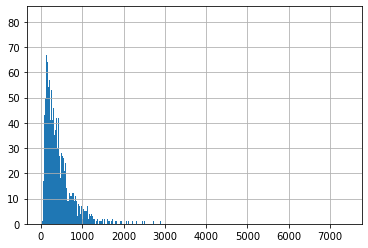

In [ ]:
# the number of characters present in each sentence
npMax = np.max(analyticsText.str.len())
analyticsText.str.len().hist(bins=npMax)

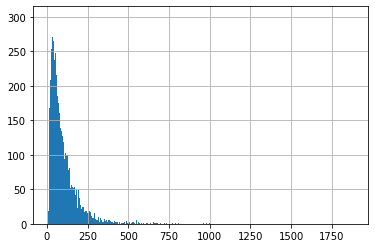

In [ ]:
# the number of words present in each sentence
npMax1 = np.max(data['word_count'])
data['word_count'].hist(bins=npMax1)

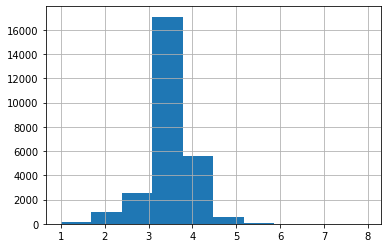

In [ ]:
# average word length in each sentence.
analyticsText.str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

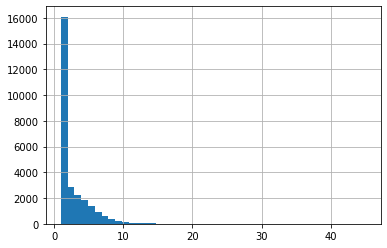

In [ ]:
# the number of sentence present in each sentence
npMax2 = np.max(data['sentence_count'])
data['sentence_count'].hist(bins=npMax2)

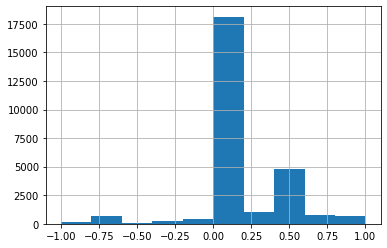

In [ ]:
# Sentiment analysis
data['polarity'].hist()

In [ ]:
# raw
corpus=[]
new= analyticsText.str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

# clean
corpusClean=[]
newClean= data['preprocess_text'].str.split()
newClean=newClean.values.tolist()
corpusClean=[word for i in newClean for word in i]

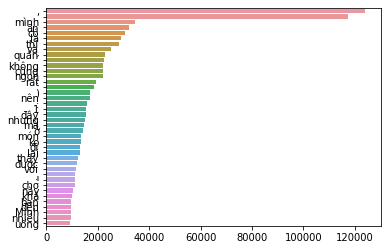

In [ ]:
# raw
from collections import Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
        x.append(word)
        y.append(count)
# top cac tu duoc dung nhieu nhat        
sns.barplot(x=y,y=x)

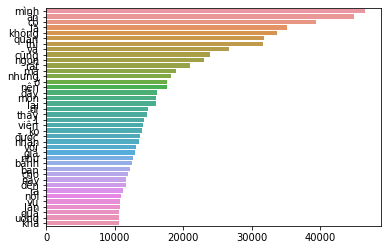

In [ ]:
# clean
counterClean=Counter(corpusClean)
mostClean=counterClean.most_common()

x, y= [], []
for word,count in mostClean[:40]:
        x.append(word)
        y.append(count)
# top cac tu duoc dung nhieu nhat        
sns.barplot(x=y,y=x)

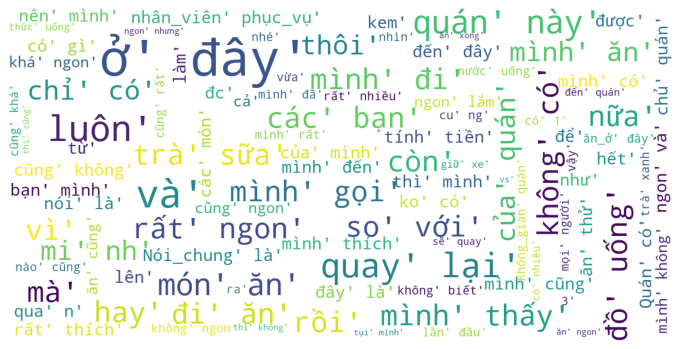

In [ ]:
# word cloud raw
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

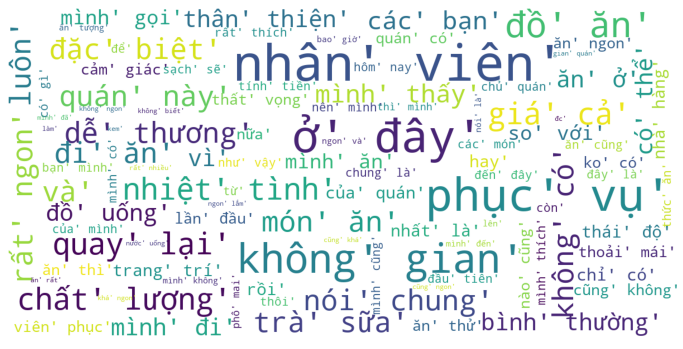

In [ ]:
# word cloud clean
show_wordcloud(corpusClean)

In [ ]:
# number each layer
# data.groupby('class')['class'].count().plot(kind="bar")

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

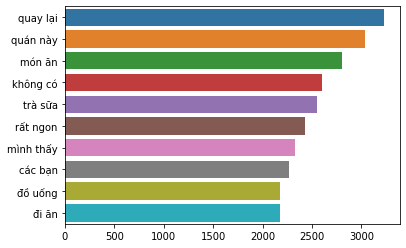

In [ ]:
# raw text
top_bi_bigrams=get_top_ngram(analyticsText,2)[:10]
x2,y2=map(list,zip(*top_bi_bigrams))
sns.barplot(x=y2,y=x2)

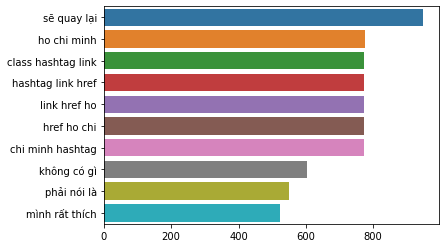

In [ ]:
# raw text
top_tri_grams=get_top_ngram(analyticsText,n=3)
x3,y3=map(list,zip(*top_tri_grams))
sns.barplot(x=y3,y=x3)

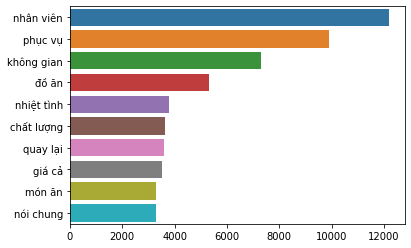

In [ ]:
# clean text
top_bi_bigrams=get_top_ngram(data['preprocess_text'],2)[:10]
x2,y2=map(list,zip(*top_bi_bigrams))
sns.barplot(x=y2,y=x2)

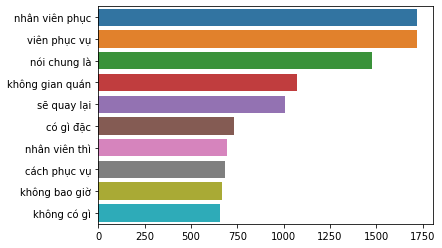

In [ ]:
# clean text
top_tri_grams=get_top_ngram(data['preprocess_text'],n=3)
x3,y3=map(list,zip(*top_tri_grams))
sns.barplot(x=y3,y=x3)

# Model

In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/MyDrive/Colabs/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("/content/drive/MyDrive/Colabs/PhoBERT_base_transformers/dict.txt")

In [ ]:
bpe.encode("Test thử bpe của PhoBert xem thế nào")

'Test thử b@@ pe của Pho@@ Ber@@ t xem thế nào'

In [ ]:
vocab.encode_line('<s> ' + 'Test dictionary : đại học công nghệ!' + ' </s>')

tensor([    0, 50398, 64000,    27,  2919,   222,   675, 64001,     2,     2],
       dtype=torch.int32)

In [ ]:
from sklearn.model_selection import train_test_split

train_sents, val_sents, train_labels, val_labels = train_test_split(trainText, labelText, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 250

train_ids = []
for sent in train_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

val_ids = []
for sent in val_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    val_ids.append(encoded_sent)
    
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [ ]:
train_masks = []
for sent in train_ids:
    mask = [int(token_id > 0) for token_id in sent]
    train_masks.append(mask)

val_masks = []
for sent in val_ids:
    mask = [int(token_id > 0) for token_id in sent]

    val_masks.append(mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained(
    "/content/drive/MyDrive/Colabs/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 2, output_hidden_states=False,
)
PHOBERT = RobertaForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Colabs/PhoBERT_base_transformers/model.bin",
    config=config
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colabs/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

In [ ]:
PHOBERT.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

In [ ]:
import random
from tqdm import notebook
device = 'cuda'
epochs = 2

param_optimizer = list(PHOBERT.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)


for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    PHOBERT.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in notebook.tqdm(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        PHOBERT.zero_grad()
        outputs = PHOBERT(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(PHOBERT.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Validation...")
    PHOBERT.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    for batch in notebook.tqdm(val_dataloader):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = PHOBERT(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
print("Training complete!")

# Save and load model

In [ ]:
import torch
SAVE_MODEL_PATH = "/content/drive/MyDrive/Colabs/saveModel/PhoBertShopee.pt"
# torch.save(PHOBERT, SAVE_MODEL_PATH)

In [ ]:
modelSave = torch.load(SAVE_MODEL_PATH)
modelSave

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
DATA_TEST_DIR = DATA_ROOT_DIR + '/test_preprocess.csv'
dataTest = pd.read_csv(DATA_TEST_DIR, index_col=0)
dataTest.head()

,text,preprocess_text
id,,
2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà...",mình kêu 6 loại khác nhau mỗi laoij 1 cục mà ă...
e3f0ea32,Ăn ở đây từ trc khi chủ nhà xây nhà mới . ch...,ăn ở đây từ trc khi chủ nhà xây nhà mới chất l...
8743eae3,Các bạn đến ăn ngay và luôn đi nhé ! !\nMình t...,các bạn đến ăn ngay và luôn đi nhé mình từ trư...
7b554248,Đây gần như quán ruột của mình luôn : ) ) đây ...,đây gần như quán ruột của mình luôn đây đồ_ăn ...
bedd1403,Tiếc là 25 năm sống ở Tây Ninh thì đây là lần ...,tiếc là 25 năm sống ở tây_ninh thì đây là lần ...


In [ ]:
val_sents[0:5]

['hình_như chất_lượng càng_ngày_càng xuống hì phải không có nhiều cải_tiến mới trong menu so với vài năm trước kem ăn thì hương_vị nhạt chán bánh_quế thì không được giòn và có_vẻ cháy cháy kêu đi kêu lại mấy lần vì nhiều món không có và hình_ảnh trong menu với thực_tế khác nhau rõ_rệt luôn không_thể tin được phục_vụ chậm_chạp và thiếu niềm_nở',
 'ăn ngon lạ_miệng có rượu_nếp uống kèm rất ngon 3 người thì bảo chị chủ quán làm 10k thôi đói bụng thì có_thể ăn no được',
 'các món ăn tại đây do đầu_bếp pháp nấu rất rất ngon mình thấy món nào cũng ngon uống với rượu_vang trong khung_cảnh nhà_hàng sang_trọng 5 sao và phục_vụ thân_thiện đẳng_cấp thật là sướng món bò angus cực_kỳ mềm thơm ngon vịt confit cũng ngon lắm lắm đặc_biệt tráng_miệng kem làm tại_chỗ bằng nitrogen thật là ngon có_lẽ ngon nhất trong các loại kem từng ăn nên thử kem mùi caramel và chanh dây bánh chôclate lava cũng thật tuyệt nên đặt bàn view q1 vì đẹp hơn view q4 túm lại rất hài_lòng với khung_cảnh phục_vụ và món ăn tại đ

In [ ]:
valLabel = val_labels[0:100]

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# test the model with some sentence
inputs = [
    "Món ăn ngon, đồ uống ngon, rẻ",
    "Món ăn ngon",
    "Tuy rẻ nhưng đồ ăn không ngon, đồ uống không ngon",
    "không gian chật hẹp, nhân viên nhiệt tình, đồ ăn ngon",
    "hàng rất tốt, đẹp, mẫu mã đa dạng, sẽ quay lại lần sau"
  ]
# inputs = val_sents[0:5]
# print(len(val_sents))
MAX_LEN = 250

test_ids = []
for sent in inputs:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    test_ids.append(encoded_sent)
test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_inputs = torch.tensor(test_ids)

test_masks = []
for sent in test_ids:
    mask = [int(token_id > 0) for token_id in sent]
    test_masks.append(mask)

test_masks = torch.tensor(test_masks)

test_data = TensorDataset(test_inputs, test_masks)

b_input_ids = test_inputs.to("cuda")
b_input_mask = test_masks.to("cuda")

outputs = modelSave(b_input_ids, 
    token_type_ids=None, 
    attention_mask=b_input_mask)

logits = outputs["logits"]
score = torch.softmax(logits, dim=-1)
Labels = ["Negative", "Positive"]

for index ,item in enumerate(inputs):
    labelItem = torch.argmax(score[index])
    if labelItem != val_labels[index]:
        print(f"The sentence: '{inputs[index]}' has {Labels[torch.argmax(score[index], dim=-1).item()]} tone with confident score : { torch.argmax(score[index], dim=-1).item()} \n" )

RuntimeError: ignored